# Binary Classification to Concept BottleNeck :-)

Import the following and get rid of warnings :-)

In [1]:
import copy
import warnings

import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

warnings.filterwarnings('ignore')

Set constants:
   - Dataset Path
   - Seed


In [2]:
DATASET_PATH = "/Users/nellygarcia/Documents/ConceptLearning/DatasetsCvs/6KSFX/DatasetFeatures.csv"
seed  = 42
number_of_classes = 59

## Convert Dataset to Pandas

In [3]:
DATASET = pd.read_csv(DATASET_PATH)
#Just do this line with features of SMILE
DATASET.columns = [col.replace("[", "_").replace("]", "_") for col in DATASET.columns]

## Drop Duplicates that are in the dataset as well as columns with Nans

In [4]:
DATASET = DATASET.drop_duplicates( keep='first', inplace=False, ignore_index=False)
DATASET = DATASET.dropna(axis=1,how='any')
DATASET.columns = map(str.lower, DATASET.columns)
feature_names = [feature for feature in DATASET.columns if feature != 'label']
labels = DATASET.iloc[:, -1] # get labels column
print(max(labels))
number_of_classes = max(labels)

60


# Label Encoder 

In [5]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)

# Convert to Pandas Series for easier debugging
y_encoded_series = pd.Series(y_encoded) 

# Print shape and mapping
print(f"y_encoded shape: {y_encoded.shape}")
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Label Mapping:", label_mapping)
encoder = LabelEncoder()
DATASET["label"] = encoder.fit_transform(DATASET["label"])

y_encoded shape: (11156,)
Label Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59}


In [6]:
DATASET

,frequency1,amplitude1,frequency2,amplitude2,frequency3,amplitude3,frequency4,amplitude4,frequency5,amplitude5,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
0,700.616577,0.002750,336.061737,0.000835,213.889648,0.000691,282.558685,0.000539,309.935699,0.000522,...,-34.993458,10.350830,22.934132,9.248787,10.823382,-16.981611,-34.167450,-31.193080,-20.820755,13
1,256.188416,0.460823,211.038208,0.423377,246.581177,0.423318,230.982010,0.388456,245.307144,0.374110,...,-16.264252,-25.370500,-23.322458,-35.137040,-18.662985,-27.665617,-34.103725,-29.888948,-25.630236,13
2,523.890198,0.007519,354.333221,0.006483,358.799866,0.005900,356.425842,0.005778,698.999695,0.005489,...,-38.919240,-9.974467,8.537470,19.683683,22.983437,21.123775,12.443456,3.117321,-3.759289,13
3,231.992493,0.564408,229.079514,0.558923,237.695145,0.529750,234.252808,0.489095,218.147659,0.480675,...,47.063133,-13.913457,-42.845400,-1.846112,-7.480192,-31.059818,-17.692130,-13.173474,-21.580227,13
4,0.000000,1.251683,0.000000,1.199665,0.000000,1.070110,0.000000,1.003533,0.000000,1.000615,...,51.903645,31.138659,15.855928,5.189063,-0.850485,-3.227352,-3.050780,-1.080239,1.528881,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11997,425.745483,0.340405,355.855469,0.333323,166.104477,0.320180,359.312073,0.308502,149.064087,0.294516,...,-2.044175,-8.563234,-4.655438,-6.648553,-7.812632,-1.791284,-3.406623,-4.087511,-4.329637,26
11998,40.966537,0.434227,79.148270,0.411303,86.149857,0.402336,42.192062,0.364310,57.154949,0.363283,...,9.978276,40.500877,9.802271,-6.550567,9.826992,11.645103,-4.973080,-6.975728,2.260789,26
11999,200.699860,0.450296,211.541458,0.407135,144.718887,0.338558,196.363541,0.330359,213.995117,0.306714,...,5.790665,-9.472850,-10.488037,-9.273581,-8.915489,-8.584075,-8.912075,-7.406622,-5.628617,26
12000,220.892014,0.301120,234.797760,0.230866,185.630630,0.224534,209.934784,0.223598,193.285248,0.222358,...,5.052430,1.089707,-6.344812,-2.422560,-5.881743,-1.577505,-2.185241,-0.124972,-1.850468,26


## Create Train and Test Dataset Splits

The train dataset will be used throughout, the Test_dataset will be saved till the end.

In [7]:
TRAIN_DATASET, TEST_DATASET, _, _ = train_test_split(
    DATASET, DATASET["label"], test_size=0.3, stratify=DATASET["label"], random_state=seed
    )
TRAIN_DATASET.shape, TEST_DATASET.shape

((7809, 59), (3347, 59))

# Copy TRAIN_DATASET into training_dataset

In [8]:
training_dataset = copy.deepcopy(TRAIN_DATASET)
testing_dataset = copy.deepcopy(TEST_DATASET)

# Hyperparameters for Biclassification

In [9]:


Important_Features_For_Class = {}
Important_Features_For_Class_value = {}
random_state = 42
accs = 0

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'subsample': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

for label in range(number_of_classes):
    Important_Features_For_Class[label] = []

    labels = training_dataset["label"]

    Features_Of_Label_To_Identify = training_dataset[training_dataset["label"] == label].copy()
    Features_Of_Label_To_Identify["label"] = 0


    Features_Of_Other_Labels = training_dataset[training_dataset["label"] != label].copy()
    Features_Of_Other_Labels = Features_Of_Other_Labels.sample(Features_Of_Label_To_Identify.shape[0], random_state=random_state)
    Features_Of_Other_Labels["label"] = 1

    # Create Binary Classification Dataset
    Binary_Classification_Dataset = pd.concat([Features_Of_Label_To_Identify, Features_Of_Other_Labels])
    
    # Split Features & Labels
    X = Binary_Classification_Dataset.drop(columns=["label"])
    y = Binary_Classification_Dataset["label"]

    # Train-Test Split
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=random_state
    )

    # Normalize Features
    X_train = (X_train - X_train.mean()) / X_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()

    # **Hyperparameter Optimization**
    Binary_XGB_Classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=random_state)

    random_search = RandomizedSearchCV(
        estimator=Binary_XGB_Classifier,
        param_distributions=param_grid,
        n_iter=10,  
        cv=10,  
        scoring='accuracy',
        n_jobs=-1,
        random_state=random_state
    )

    random_search.fit(X_train, Y_train)
    best_model = random_search.best_estimator_

    # Evaluate Optimized Model
    predictions = best_model.predict(X_test)
    xgb_accuracy = accuracy_score(Y_test, predictions)
    accs += xgb_accuracy
    xgb_f1_score = f1_score(Y_test, predictions, average='weighted')

    print(f"CLASS {label}:")
    print("Best Hyperparameters:", random_search.best_params_)
    print("Classifier F1 Score:", xgb_f1_score)
    print("Classifier Accuracy:", xgb_accuracy)
 # Get Feature Importance and Allocate to  now it's best model not the Regression tree
    importance = pd.DataFrame(best_model.feature_importances_)
    importance.sort_values(by=0,ignore_index=False,ascending=True,inplace=True)
    importance = importance.iloc[np.count_nonzero(best_model.feature_importances_== 0):][::-1]
    Important_Features_For_Class[label] = list(training_dataset.keys()[importance.index.values])
    Important_Features_For_Class_value[label] = importance.values


CLASS 0:
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.7}
Classifier F1 Score: 0.9857113696672789
Classifier Accuracy: 0.9857142857142858
CLASS 1:
Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}
Classifier F1 Score: 0.8900967982129562
Classifier Accuracy: 0.8902439024390244
CLASS 2:
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}
Classifier F1 Score: 0.9146214487579949
Classifier Accuracy: 0.9146341463414634
CLASS 3:
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}
Classifier F1 Score: 0.971830985915493
Classifier Accuracy: 0.971830985915493
CLASS 4:
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learn

CLASS 36:
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.5}
Classifier F1 Score: 0.6334532733633184
Classifier Accuracy: 0.6533333333333333
CLASS 37:
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
Classifier F1 Score: 0.9198290598290598
Classifier Accuracy: 0.92
CLASS 38:
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.5}
Classifier F1 Score: 0.9124863259884357
Classifier Accuracy: 0.9125
CLASS 39:
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}
Classifier F1 Score: 0.8619607843137256
Classifier Accuracy: 0.8625
CLASS 40:
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2

# Plot how the number of Important Features Varies how many unique Features are Required

In [10]:
uniques = []
number_of_features = np.arange(1,len(feature_names)+1)
for number_of_important_features in number_of_features:
    unique_features = []
    for label in range(10):
        for feature in Important_Features_For_Class[label][:number_of_important_features]:
            if feature not in unique_features:
                unique_features.append(feature)
    uniques.append(len(unique_features))

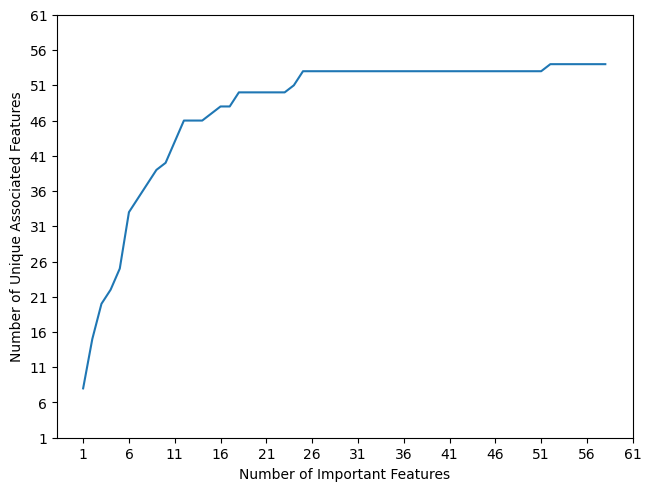

In [11]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(number_of_features, uniques)
ax.set_xlabel('Number of Important Features')
ax.set_ylabel('Number of Unique Associated Features')
plt.xticks(np.arange(1, len(number_of_features)+1+5,5))
plt.yticks(np.arange(1, len(number_of_features)+1+5,5))
plt.show()

# Create One Hot Encoding of Important Features

In [12]:
number_of_important_features = 5

class_one_hot_features = {}
class_zero_features = {}
for label in range(number_of_classes):
    class_one_hot_features[label] = []
    for feature in Important_Features_For_Class[label][:number_of_important_features]:
        class_one_hot_features[label].append(feature)
for label in range(number_of_classes):
    class_zero_features[label] = []
    for feature in feature_names:
        if feature not in class_one_hot_features[label]:
            class_zero_features[label].append(feature)
            
from scipy.special import softmax
OneHotEncodedDataset = copy.deepcopy(training_dataset)
OneHotEncodedDataset_test = copy.deepcopy(testing_dataset)
for label in range(number_of_classes):
    Important_Features_For_Class_value[label][:number_of_important_features] = softmax(Important_Features_For_Class_value[label][:number_of_important_features], axis=0)

    OneHotEncodedDataset.loc[OneHotEncodedDataset['label'].eq(label),class_one_hot_features[label]] = Important_Features_For_Class_value[label][:number_of_important_features].T
    OneHotEncodedDataset.loc[OneHotEncodedDataset['label'].eq(label),class_zero_features[label]]=0
    OneHotEncodedDataset_test.loc[OneHotEncodedDataset_test['label'].eq(label),class_one_hot_features[label]] = Important_Features_For_Class_value[label][:number_of_important_features].T
    OneHotEncodedDataset_test.loc[OneHotEncodedDataset_test['label'].eq(label),class_zero_features[label]]=0

# Print Class Concepts

In [13]:
for key in class_one_hot_features:
    print(key, class_one_hot_features[key])
    

0 ['pitchsalience', 'pitchconfidence', 'attackstart', 'dyncomplexity', 'amplitude5']
1 ['pitchconfidence', 'mfcc_3', 'amplitude3', 'frequency1', 'mfcc_6']
2 ['amplitude2', 'amplitude4', 'pitchsalience', 'amplitude1', 'maxtototal']
3 ['pitchsalience', 'spectralflux', 'dyncomplexity', 'crest', 'mfcc_3']
4 ['logattacktime', 'flatnesssfx', 'mfcc_1', 'ldb', 'intensity']
5 ['crest', 'effectiveduration', 'frequency1', 'pitchconfidence', 'attackstart']
6 ['loudness', 'effectiveduration', 'ldb', 'rms', 'mfcc_1']
7 ['loudness', 'rms', 'ldb', 'median', 'spectralflux']
8 ['highfrequencycontent', 'loudness', 'attackstart', 'mfcc_3', 'crest']
9 ['attackstart', 'amplitude1', 'logattacktime', 'maxtototal', 'amplitude2']
10 ['tctototal', 'flatnesssfx', 'dyncomplexity', 'mfcc_11', 'amplitude1']
11 ['attackstart', 'tctototal', 'zcr', 'attackstop', 'amplitude2']
12 ['highfrequencycontent', 'variance', 'frequency3', 'frequency5', 'mfcc_1']
13 ['pitchsalience', 'variance', 'ldb', 'crest', 'mfcc_13']
14 ['tc

In [14]:
top_features_per_class = {
    label: Important_Features_For_Class[label][:number_of_important_features]
    for label in Important_Features_For_Class
}

# Convert dictionary to DataFrame and transpose it for readability
df_top_features = pd.DataFrame.from_dict(top_features_per_class, orient="index")

# Rename columns for clarity
df_top_features.columns = [f"Feature_{i+1}" for i in range(df_top_features.shape[1])]

# Save to CSV
df_top_features.to_csv("6KSFX88Top5.csv", index_label="Class")


# Create Datasets

In [15]:
important_features = list(set().union(*class_one_hot_features.values()))[:number_of_important_features]

# Train Dataset
Features_train = training_dataset[feature_names]  # Features
Features_train=(Features_train-Features_train.mean())/Features_train.std()
Concepts_train = OneHotEncodedDataset[feature_names]
Classes_train = training_dataset["label"]
# Test Dataset
Features_test = testing_dataset[feature_names]
Features_test=(Features_test-Features_test.mean())/Features_test.std()
Concepts_test = OneHotEncodedDataset_test[feature_names]
Classes_test = testing_dataset["label"]
# # Check final dataset sizes
print(f"Features_train shape: {Features_train.shape}, Concepts_train shape: {Concepts_train.shape}, Classes_Train shape: {Classes_train.shape}")
print(f"Features_test shape: {Features_test.shape}, Concepts_test shape: {Concepts_test.shape},  Classes_test shape: {Classes_test.shape}")

#print(f"Concepts_train shape before normalization: {Concepts_train.shape}")print(f"Expected shape: ({training_dataset.shape[0]}, {number_of_important_features})")


Features_train shape: (7809, 58), Concepts_train shape: (7809, 58), Classes_Train shape: (7809,)
Features_test shape: (3347, 58), Concepts_test shape: (3347, 58),  Classes_test shape: (3347,)


# Baseline Accuracy

In [16]:
xgb_classifier = xgb.XGBClassifier(random_state=seed,max_leaves=0)
xgb_classifier.fit(Features_train, Classes_train)
classes_predictions = xgb_classifier.predict(Features_test)
baseline_xgb_accuracy = accuracy_score(classes_predictions, Classes_test.values.astype(int))
baseline_xgb_f1_score = f1_score(Classes_test.values.astype(int), classes_predictions, average='weighted')
print("FPC Classifier F1 Score:", baseline_xgb_accuracy)
print("FPC Classifier Accuracy:", baseline_xgb_f1_score)

FPC Classifier F1 Score: 0.5667762175082163
FPC Classifier Accuracy: 0.5701164088097332


# Train Feature to Concept Classifier Model

This will take about 2 minutes

In [18]:
feature2concept_classifier = xgb.XGBRegressor(tree_method="hist",multi_strategy="multi_output_tree", random_state=seed)
feature2concept_classifier.fit(Features_train, Concepts_train)


[10:01:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "multi_strategy" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

# Get predicted Concepts for Training Dataset

In [19]:
concept_predictions_train = feature2concept_classifier.predict(Features_train)

# Train Concept to Class Classifier Model

In [20]:
concept2class_xgb_classifier = xgb.XGBClassifier(random_state=seed)
concept2class_xgb_classifier.fit(concept_predictions_train,Classes_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [21]:
def concept_accuracy(prediction, ground_truth):
    accuracies = []
    print(prediction.shape,ground_truth.shape)
    for idx in range(prediction.shape[0]):
        accuracies.append(accuracy_score(prediction[idx], ground_truth[idx]))
    return np.mean(accuracies)

# Train Accuracy

In [22]:
print("Train Acc")
concept_predictions_train = feature2concept_classifier.predict(Features_train)
print(concept_predictions_train.shape, Concepts_train.shape)
# xgb_accuracy = concept_accuracy(concept_predictions_train, Concepts_train.values)
# print("FPC PCAs Accuracy:", xgb_accuracy)
classes_predictions = concept2class_xgb_classifier.predict(concept_predictions_train)
xgb_accuracy = accuracy_score(classes_predictions, Classes_train.values.astype(int))
xgb_f1_score = f1_score(Classes_train.values.astype(int), classes_predictions, average='weighted')
print("FPC Classifier F1 Score:", xgb_f1_score)
print("FPC Classifier Accuracy:", xgb_accuracy)


Train Acc
(7809, 58) (7809, 58)
FPC Classifier F1 Score: 0.9988478647612653
FPC Classifier Accuracy: 0.9988474836726854


# Test Accuracy

In [23]:
print("Test Acc")
concept_predictions = feature2concept_classifier.predict(Features_test)
# xgb_accuracy = concept_accuracy(concept_predictions, Concepts_test.values)
# print("FPC PCAs Accuracy:", xgb_accuracy)
classes_predictions = concept2class_xgb_classifier.predict(concept_predictions)
CBN_xgb_accuracy = accuracy_score(classes_predictions, Classes_test.values.astype(int))
CBN_xgb_f1_score = f1_score(Classes_test.values.astype(int), classes_predictions, average='weighted')
print("FPC Classifier F1 Score:", CBN_xgb_accuracy)
print("FPC Classifier Accuracy:", CBN_xgb_f1_score)

Test Acc
FPC Classifier F1 Score: 0.2814460711084553
FPC Classifier Accuracy: 0.30152453312713634


# Performance Difference

In [24]:
print(f"Accuracy Difference: {baseline_xgb_accuracy - CBN_xgb_accuracy:.4f}")
print(f"F1 Score Difference: {baseline_xgb_f1_score - CBN_xgb_f1_score:.4f}")

Accuracy Difference: 0.2853
F1 Score Difference: 0.2686


# Confussion Matrix

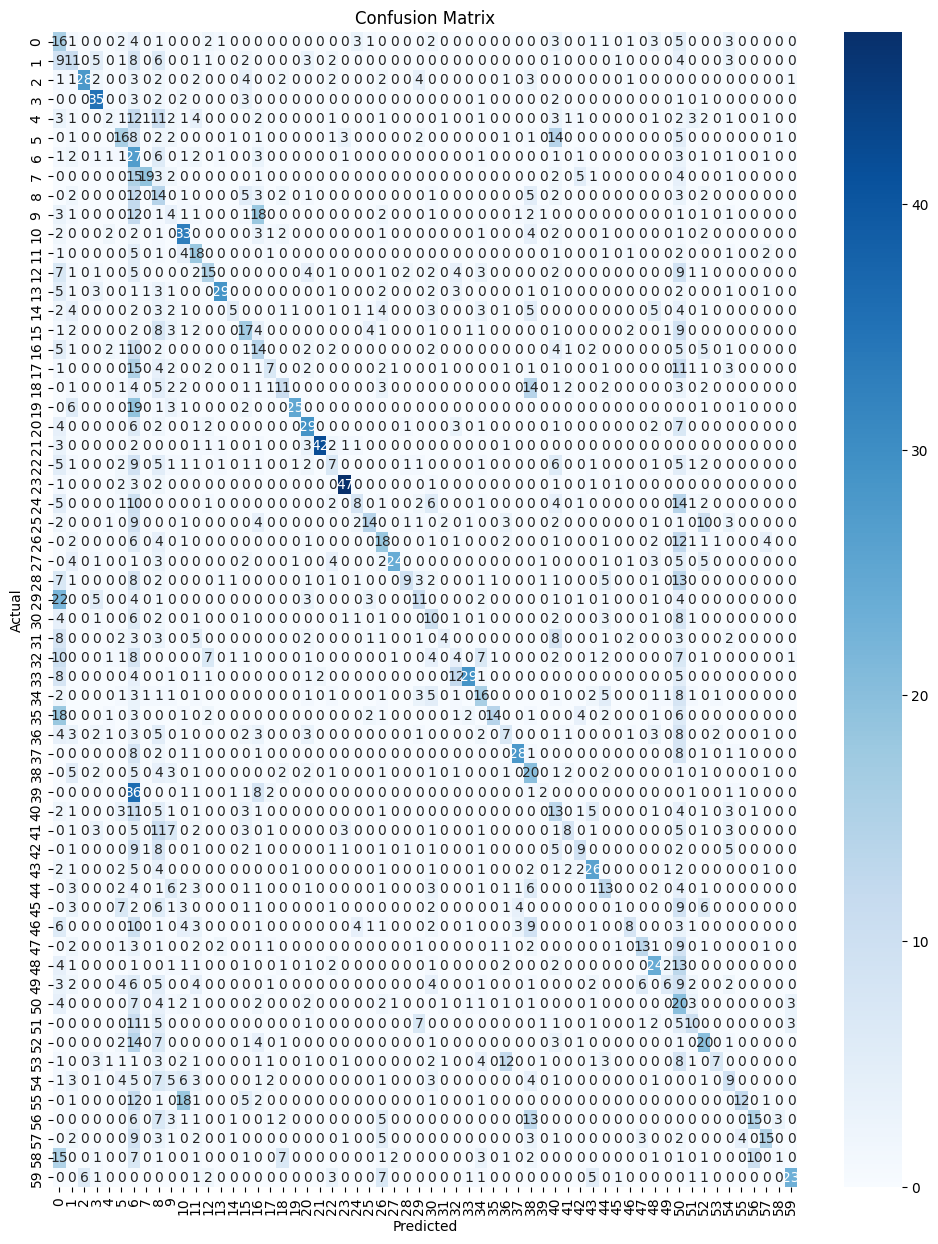

Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.32      0.13        50
           1       0.15      0.19      0.17        58
           2       0.82      0.47      0.60        59
           3       0.52      0.70      0.60        50
           4       0.17      0.03      0.06        59
           5       0.28      0.27      0.27        59
           6       0.06      0.48      0.11        56
           7       0.79      0.36      0.49        53
           8       0.07      0.26      0.11        53
           9       0.07      0.08      0.07        52
          10       0.35      0.57      0.43        58
          11       0.24      0.47      0.32        38
          12       0.42      0.25      0.31        61
          13       0.81      0.50      0.62        58
          14       0.45      0.10      0.16        50
          15       0.27      0.28      0.27        61
          16       0.16      0.23      0.19        60
    

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Classes_test.values.astype(int), classes_predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage


# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(12, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(Classes_test), yticklabels=set(Classes_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(Classes_test.values.astype(int), classes_predictions))


In [26]:

class_labels = np.unique(Classes_test)  # Get class labels

# Convert to DataFrame
confusion_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Calculate misclassifications per class
misclassified_counts = confusion_df.sum(axis=1) - np.diag(cm)

# Find the most confused classes for each class
most_confused_with = confusion_df.copy()
np.fill_diagonal(most_confused_with.values, 0)  # Remove diagonal (correct predictions)
most_confused_class = most_confused_with.idxmax(axis=1)  # Get the most confused class per row

# Create summary DataFrame
misclassification_summary = pd.DataFrame({
    "Misclassified Count": misclassified_counts,
    "Most Confused With": most_confused_class
}).sort_values(by="Misclassified Count", ascending=False)

# Display Results
print("**Misclassification Breakdown Per Class** ")
print(misclassification_summary)



**Misclassification Breakdown Per Class** 
    Misclassified Count  Most Confused With
32                   57                   0
4                    57                   6
58                   55                   0
39                   54                   6
49                   52                  50
17                   52                   6
28                   51                  50
46                   51                   6
24                   51                  50
53                   50                  36
22                   50                   6
54                   49                   8
41                   49                   8
29                   48                   0
9                    48                  16
45                   47                  50
1                    47                   0
36                   47                  50
16                   46                   6
12                   46                  50
18                   45          